# Install or upgrade libraries

It might be that you are running with the latest libraries and that they all work together fine.

Running the following cell takes a minute or so but ensures that you have a consistent set of python tools.

In [1]:
import sys
print(f"{sys.version = }\n")


sys.version = '3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0]'



In [2]:
# If there are issues with fsspect-xrootd not being found, run this outside of Jupyter-notebook and restart
# !pip install --upgrade fsspec-xrootd

In [3]:
#'''
!pip install --upgrade pip

!pip install futures

!pip install --user --upgrade coffea

!pip install --upgrade awkward
!pip install --upgrade uproot

!pip install --upgrade fsspec-xrootd

!pip install vector

!pip install --upgrade pandas


!pip install --upgrade matplotlib
#'''

We've also prepared some helper code that makes it easier to work with the data in this lesson.

You can see the code [here](https://github.com/cms-opendata-workshop/workshop2024-lesson-event-selection/blob/main/instructors/dpoa_workshop_utilities.py) but we will explain the functions and data objects in this notebook.

Let's download it first.

In [4]:
!wget https://raw.githubusercontent.com/cms-opendata-workshop/workshop2024-lesson-event-selection/main/instructors/dpoa_workshop_utilities.py

--2025-06-04 13:21:29--  https://raw.githubusercontent.com/cms-opendata-workshop/workshop2024-lesson-event-selection/main/instructors/dpoa_workshop_utilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9657 (9.4K) [text/plain]
Saving to: ‘dpoa_workshop_utilities.py.4’

dpoa_workshop_utili 100%[===================>]   9.43K  --.-KB/s    in 0s      

2025-06-04 13:21:29 (57.8 MB/s) - ‘dpoa_workshop_utilities.py.4’ saved [9657/9657]



## Imports

Import all the libraries we will need and check their versions, in case you run into issues.

In [5]:
%load_ext autoreload
%autoreload 2

# The classics
import numpy as np
import matplotlib.pylab as plt
import matplotlib # To get the version

import pandas as pd

# The newcomers
import awkward as ak
import uproot

import vector
vector.register_awkward()

import requests
import os

import time

import json

import dpoa_workshop_utilities
from dpoa_workshop_utilities import nanoaod_filenames
from dpoa_workshop_utilities import get_files_for_dataset
from dpoa_workshop_utilities import pretty_print
from dpoa_workshop_utilities import build_lumi_mask

import sys

In [6]:
print("Versions --------\n")
print(f"{sys.version = }\n")
print(f"{ak.__version__ = }\n")
print(f"{uproot.__version__ = }\n")
print(f"{np.__version__ = }\n")
print(f"{matplotlib.__version__ = }\n")
print(f"{vector.__version__ = }\n")
print(f"{pd.__version__ = }\n")

Versions --------

sys.version = '3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0]'

ak.__version__ = '2.8.3'

uproot.__version__ = '5.6.2'

np.__version__ = '1.26.4'

matplotlib.__version__ = '3.10.3'

vector.__version__ = '1.6.2'

pd.__version__ = '2.2.3'



# Opening a file

Let's open and explore a sample file.

We'll be getting the data from [here](https://opendata.cern.ch/record/67993).

This is some Monte Carlo that contains simulations of a top-antitop pair being created in a proton-proton collision at CMS.

One top decays leptonically and the other decays hadronically.

**Do you know what leptonically and hadronically mean? If not, do a bit of research.**

When you go to open the file, it might take 10-30 seconds at this step if you are working with the larger file.

In [7]:
# For testing
# Big file
#filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'

# Smaller file, better for prototyping your code as things will run faster
filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'

print(f"Opening...{filename}")
f = uproot.open(filename)

events = f['Events']

nevents = events.num_entries

print(f"{nevents = }")

Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root
nevents = 168000


The `events` object is a `TTree` implementation in python and behaves like a dictionary. This means
we can get all the keys if we want.

In [8]:
# Uncomment the following line to print all the keys

print(events.keys())

['run', 'luminosityBlock', 'event', 'HTXS_Higgs_pt', 'HTXS_Higgs_y', 'HTXS_stage1_1_cat_pTjet25GeV', 'HTXS_stage1_1_cat_pTjet30GeV', 'HTXS_stage1_1_fine_cat_pTjet25GeV', 'HTXS_stage1_1_fine_cat_pTjet30GeV', 'HTXS_stage1_2_cat_pTjet25GeV', 'HTXS_stage1_2_cat_pTjet30GeV', 'HTXS_stage1_2_fine_cat_pTjet25GeV', 'HTXS_stage1_2_fine_cat_pTjet30GeV', 'HTXS_stage_0', 'HTXS_stage_1_pTjet25', 'HTXS_stage_1_pTjet30', 'HTXS_njets25', 'HTXS_njets30', 'nboostedTau', 'boostedTau_chargedIso', 'boostedTau_eta', 'boostedTau_leadTkDeltaEta', 'boostedTau_leadTkDeltaPhi', 'boostedTau_leadTkPtOverTauPt', 'boostedTau_mass', 'boostedTau_neutralIso', 'boostedTau_phi', 'boostedTau_photonsOutsideSignalCone', 'boostedTau_pt', 'boostedTau_puCorr', 'boostedTau_rawAntiEle2018', 'boostedTau_rawIso', 'boostedTau_rawIsodR03', 'boostedTau_rawMVAnewDM2017v2', 'boostedTau_rawMVAoldDM2017v2', 'boostedTau_rawMVAoldDMdR032017v2', 'boostedTau_charge', 'boostedTau_decayMode', 'boostedTau_jetIdx', 'boostedTau_rawAntiEleCat2018',

Again, we have provided you with a helper function called `pretty_print` that will print subsets of the keys, based on strings
that you require or ignore.

It will also format that output based on how many characters you want in a column (you are limited to 80 characters per line).

Here is some example usage.

In [9]:
# Pretty print all the keys with the default format
#pretty_print(events.keys())

# Pretty print keys with 30 characters per column, for keys that contain `FatJet`
#pretty_print(events.keys(), fmt='30s', require='FatJet')

# Pretty print keys with 40 characters per column, for keys that contain `Muon` and `Iso` but ignore ones with `HLT`
pretty_print(events.keys(), fmt='40s', require=['Muon'], ignore='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `HLT` and `TkMu50`
#pretty_print(events.keys(), fmt='40s', require=['HLT', 'TkMu50'])

# Pretty print keys with 40 characters per column, for keys that contain `HLT`
#pretty_print(events.keys(), fmt='40s', require='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `Jet_` but ignore ones with `Fat`
#pretty_print(events.keys(), fmt='40s', require='Jet_', ignore='Fat')

# Pretty print keys with 40 characters per column, for keys that contain `PuppiMET` but ignore ones with `Raw`
#pretty_print(events.keys(), fmt='40s', require='PuppiMET', ignore='Raw')

Jet_nMuons                               L1PreFiringWeight_Muon_Nom               
L1PreFiringWeight_Muon_StatDn            L1PreFiringWeight_Muon_StatUp            
L1PreFiringWeight_Muon_SystDn            L1PreFiringWeight_Muon_SystUp            
nMuon                                    Muon_dxy                                 
Muon_dxyErr                              Muon_dxybs                               
Muon_dz                                  Muon_dzErr                               
Muon_eta                                 Muon_ip3d                                
Muon_jetPtRelv2                          Muon_jetRelIso                           
Muon_mass                                Muon_miniPFRelIso_all                    
Muon_miniPFRelIso_chg                    Muon_pfRelIso03_all                      
Muon_pfRelIso03_chg                      Muon_pfRelIso04_all                      
Muon_phi                                 Muon_pt                                  
Muon

## Extract some data

We're going to pull out subsets of the data in order to do our analysis.

As a reminder, you can find a list of the variable names in each dataset on the CERN Open Data Portal page for that dataset, for example, [here](https://opendata.cern.ch/eos/opendata/cms/dataset-semantics/NanoAODSIM/75156/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8_doc.html).

We're going to work with the following sets of variables
* `FatJet` for jets that are merges
* `Jet` for non-merged jets
* `Muon` for muons
* `PuppiMET` which is missing energy in the transverse plane (MET) for pileup per particle identification (Puppi)

Running this cell might take a little bit if you are running over the bigger file. However, once you pull out the values, later calculations are much faster.

In [10]:
# Jets ---------------------------------------------------
# B-tagging variable
jet_btag = events['Jet_btagDeepB'].array()

# Measure of quality of measurement of jet
jet_jetid = events['Jet_jetId'].array()

# 4-momentum in pt, eta, phi, mass
jet_pt = events['Jet_pt'].array()
jet_eta = events['Jet_eta'].array()
jet_phi = events['Jet_phi'].array()
jet_mass = events['Jet_mass'].array()


# Muons ---------------------------------------------------
# Muon isolation
muon_iso = events['Muon_miniIsoId'].array()

# Measure of quality of how well the muon is reconstructed
muon_tightId = events['Muon_tightId'].array()

# 4-momentum in pt, eta, phi, mass
muon_pt = events['Muon_pt'].array()
muon_eta = events['Muon_eta'].array()
muon_phi = events['Muon_phi'].array()
muon_mass = events['Muon_mass'].array()


# MET ------------------------------------------------------
# 3-momentum in pt, eta, phi, mass
met_pt = events['PuppiMET_pt'].array()
met_eta = 0*events['PuppiMET_pt'].array()  # Fix this to be 0
met_phi = events['PuppiMET_phi'].array()

# What comes next?

In [11]:
def process_file(filename):
    """
    Root file processing function;
    
    ############################
    ########## INPUTS ##########
    ############################
    
    filename (str, default=None) - Full root file destination

    #############################
    ########## RETURNS ##########
    #############################
    
    events (uproot.model (Tree)) - Root file keys
    """
    ############################################
    ########## OPENING SPECIFIED FILE ##########
    ############################################
    print(f"Opening...{filename}")
    
    try:
        f = uproot.open(filename)
    except:
        print(f"Could not open {filename}")
        return None

    ####################################################################
    ########## ACCESSING EVENTS AND MAKING SPECIFIC VARIABLES ##########_jet_cut
    ####################################################################
    
    events = f['Events']

    nevents = events.num_entries

    print(f"{nevents = }")

    # # FatJet -----------------------------------------------------
    # fatjet_mSD = events['FatJet_msoftdrop'].array()

    # fatjet_tag = events['FatJet_particleNet_TvsQCD'].array()

    # fatjet_tau2 = events['FatJet_tau2'].array()
    # fatjet_tau3 = events['FatJet_tau3'].array()

    # fatjet_pt = events['FatJet_pt'].array()
    # fatjet_eta = events['FatJet_eta'].array()
    # fatjet_phi = events['FatJet_phi'].array()
    # fatjet_mass = events['FatJet_mass'].array()
    
    # # Muons -------------------------------------------------------
    # muon_pt = events['Muon_pt'].array()
    # muon_eta = events['Muon_eta'].array()
    # muon_phi = events['Muon_phi'].array()
    # muon_mass = events['Muon_mass'].array()

    # muon_iso = events['Muon_miniIsoId'].array()

    # muon_tightId = events['Muon_tightId'].array()

    
    # # Jets -------------------------------------------------------
    # jet_btag = events['Jet_btagDeepB'].array()
    # jet_jetid = events['Jet_jetId'].array()

    # jet_pt = events['Jet_pt'].array()
    # jet_eta = events['Jet_eta'].array()
    # jet_phi = events['Jet_phi'].array()
    # jet_mass = events['Jet_mass'].array()
    
    # # MET ---------------------------------------------------------
    # met_pt = events['PuppiMET_pt'].array()
    # met_eta = 0*events['PuppiMET_pt'].array()  # Fix this to be 0
    # met_phi = events['PuppiMET_phi'].array() 

    # ht_lep = muon_pt + met_pt
    
    # ##########################
    # ########## CUTS ##########
    # ##########################

    # # Particle-specific cuts --------------------------------------
    # tau32 = fatjet_tau3/fatjet_tau2

    # #cut_fatjet = (tau32>0.67) & (fatjet_eta>-2.4) & (fatjet_eta<2.4) & (fatjet_mSD>105) & (fatjet_mSD<220)
    # cut_fatjet = (fatjet_pt > 500) & (fatjet_tag > 0.5)

    # cut_muon = (muon_pt>55) & (muon_eta>-2.4) & (muon_eta<2.4) & \
    #            (muon_tightId == True) & (muon_iso>1) & (ht_lep>150)

    # cut_jet = (jet_btag > 0.5) & (jet_jetid>=4)



    # # Event cuts -------------------------------------------------
    # cut_met = (met_pt > 50)

    # cut_nmuons = ak.num(cut_muon[cut_muon]) == 1
    # cut_njets = ak.num(cut_jet[cut_jet]) == 1


    # cut_trigger = (events['HLT_TkMu50'].array())
    
    # cut_ntop = ak.num(cut_fatjet[cut_fatjet]) == 1

    # cut_full_event = None
    # if IS_DATA:    
    #     mask_lumi = build_lumi_mask('Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt', events)#, verbose=True)
    #     cut_full_event = cut_trigger & cut_nmuons & cut_met & cut_ntop & mask_lumi
    # else:
    #     cut_full_event = cut_trigger & cut_nmuons & cut_met & cut_ntop
        
    # #############################################
    # ########## CALCULATING DI-TOP MASS ##########
    # #############################################
    
    # fatjets = ak.zip(
    #     {"pt": fatjet_pt[cut_full_event][cut_fatjet[cut_full_event]], 
    #      "eta": fatjet_eta[cut_full_event][cut_fatjet[cut_full_event]], 
    #      "phi": fatjet_phi[cut_full_event][cut_fatjet[cut_full_event]], 
    #      "mass": fatjet_mass[cut_full_event][cut_fatjet[cut_full_event]]},
    #     with_name="Momentum4D",
    # )

    # muons = ak.zip(
    #     {"pt": muon_pt[cut_full_event][cut_muon[cut_full_event]], 
    #      "eta": muon_eta[cut_full_event][cut_muon[cut_full_event]], 
    #      "phi": muon_phi[cut_full_event][cut_muon[cut_full_event]], 
    #      "mass": muon_mass[cut_full_event][cut_muon[cut_full_event]]},
    #     with_name="Momentum4D",
    # )

    # jets = ak.zip(
    #     {"pt": jet_pt[cut_full_event][cut_jet[cut_full_event]], 
    #      "eta": jet_eta[cut_full_event][cut_jet[cut_full_event]], 
    #      "phi": jet_phi[cut_full_event][cut_jet[cut_full_event]], 
    #      "mass": jet_mass[cut_full_event][cut_jet[cut_full_event]]},
    #     with_name="Momentum4D",
    # )

    # met = ak.zip(
    #     {"pt": met_pt[cut_full_event], 
    #      "eta": met_eta[cut_full_event], 
    #      "phi": met_phi[cut_full_event], 
    #      "mass": 0}, # We assume this is a neutrino with 0 mass
    #     with_name="Momentum4D",
    # )
    
    return events

def plot_func(events=events, pt_cut_vals=[0], btag_cut="none"):
    """
    Plotting Function

    Plots histograms of Jet and Muon Transverse Momentum and respective numbers
    
    ############################
    ########## INPUTS ##########
    ############################
    
    events_keys (uproot.model (Tree), default=None) - Root file keys; Can be entered to skip re-processing of root file
    
    plot (bool, default=False) - Calls plotting function if set to True
    
    cut_vals (int/float list, default=[0]) - Transverse momentum cut values
    
    btag_cut (str, default="none") - None, Loose, Medium, Tight cut using Jet_btagDeepB and Jet_btagDeepFlavB

    #############################
    ########## RETURNS ##########
    #############################

    None.
    """
    
    ################################################
    ########## VARIABLES FROM EVENTS FILE ##########
    ################################################
    
    # Muons -------------------------------------------------------
    muon_pt = events['Muon_pt'].array()
    # muon_eta = events['Muon_eta'].array()
    # muon_phi = events['Muon_phi'].array()
    # muon_mass = events['Muon_mass'].array()

    # muon_iso = events['Muon_miniIsoId'].array()

    # muon_tightId = events['Muon_tightId'].array()

    
    # Jets -------------------------------------------------------
    jet_btag = events['Jet_btagDeepB'].array()
    # jet_jetid = events['Jet_jetId'].array()

    jet_pt = events['Jet_pt'].array()
    # jet_eta = events['Jet_eta'].array()
    # jet_phi = events['Jet_phi'].array()
    # jet_mass = events['Jet_mass'].array()

    ###################################
    ########## APPLYING CUTS ##########
    ###################################

    for cut in pt_cut_vals:
        pt_jet_cut = jet_pt > cut
        
        ## B-Tagging ----------------------------------------------------
        if btag_cut == "tight" or btag_cut == "Tight":
            deep_b_tag = events["Jet_btagDeepB"].array() > 0.8767
            deep_flavb_tag = events["Jet_btagDeepFlavB"].array() > 0.6377
            btag = deep_b_tag & deep_flavb_tag

            cut_jets = jet_pt[pt_jet_cut[btag]]

        elif btag_cut == "medium" or btag_cut == "Medium":
            deep_b_tag = events["Jet_btagDeepB"].array() > 0.5847
            deep_flavb_tag = events["Jet_btagDeepFlavB"].array() > 0.2489
            btag = deep_b_tag & deep_flavb_tag

            cut_jets = jet_pt[pt_jet_cut[btag]]

        elif btag_cut == "loose" or btag_cut == "Loose":
            deep_b_tag = events["Jet_btagDeepB"].array() > 0.1918
            deep_flavb_tag = events["Jet_btagDeepFlavB"].array() > 0.0480
            btag = deep_b_tag & deep_flavb_tag

            cut_jets = jet_pt[pt_jet_cut[btag]]

        else:
            cut_jets = jet_pt[pt_jet_cut]

        
        pt_muon_cut = muon_pt > cut
        cut_muons = muon_pt[pt_muon_cut]

        ##############################
        ########## PLOTTING ##########
        ##############################
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5), tight_layout=True)
        
        fig.text(0.27,0.92, f"Jets : $p_T$>{cut} (GeV/$c$) | BTag: {btag_cut}", ha='center', fontsize=18)
        fig.text(0.77, 0.92, f"Muons : $p_T$>{cut} (GeV/$c$)", ha='center', fontsize=18)
        
        ## Jets -------------------------------------------------------------
        ax1.hist(ak.flatten(cut_jets), 
                 bins=100,label=f"Number of Jets:{ak.sum(ak.num(cut_jets))}",
                range=(0,400))
        ax1.set_xlabel("Transverse Momentum",fontsize=14)
        ax1.set_ylabel("Counts",fontsize=14)
        ax1.legend()

        ax2.hist(ak.num(cut_jets), 
                 bins=100,label=f"Number of Jets:{ak.sum(ak.num(cut_jets))}",
                range=(0,10))
        ax2.set_xlabel("Number of Jets",fontsize=14)
        #ax2.set_ylabel("Counts")
        #ax2.title(f"Jets : $p_T$>{cut} (GeV/$c$)")
        ax2.legend()

        ## Muons --------------------------------------------------------------
        ax3.hist(ak.flatten(cut_muons), 
                 bins=100,label=f"Number of Muons:{ak.sum(ak.num(cut_muons))}",
                range=(0,400), color="darksalmon")
        ax3.set_xlabel("Transverse Momentum",fontsize=14)
        #ax3.set_ylabel("Counts")
        ax3.legend()

        ax4.hist(ak.num(cut_muons), 
                 bins=100,label=f"Number of Muons:{ak.sum(ak.num(cut_muons))}",
                range=(0,5), color="darksalmon")
        ax4.set_xlabel("Number of Muons",fontsize=14)
        #ax4.set_ylabel("Counts")
        #ax4.title(f"Muons : $p_T$>{cut} (GeV/$c$)")
        ax4.legend()

        plt.tight_layout(rect=[0,0,1,0.93])

def main(filename=None, events_keys=None, plot=False, pt_cut_vals=[0], btag_cut="none"):
    """
    Main calling function for process_file and plot_func functions
    
    ############################
    ########## INPUTS ##########
    ############################
    
    filename (str, default=None) - Full root file destination
    
    events_keys (uproot.model (Tree), default=None) - Root file keys; Can be entered to skip re-processing of root file
    
    plot (bool, default=False) - Calls plotting function if set to True
    
    cut_vals (int/float list, default=[0]) - Transverse momentum cut values
    
    btag_cut (str, default="none") - None, Loose, Medium, Tight cut using Jet_btagDeepB and Jet_btagDeepFlavB

    #############################
    ########## RETURNS ##########
    #############################
    
    events (uproot.model (Tree)) - Root file keys
    """

    if events_keys is None:
        events = process_file(filename)

    elif events_keys is not None:
        events = events_keys
    
    if plot == True:
        plot_func(events, pt_cut_vals, btag_cut);

    return events

In [12]:
events = main(filename)

Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root
nevents = 168000


In [13]:
type(events)

uproot.models.TTree.Model_TTree_v20

In [14]:
print(f"Number of jets: {len(ak.flatten(jet_pt))}")
print(f"Number of muons: {len(ak.flatten(muon_pt))}")

Number of jets: 1247966
Number of muons: 151820


In [16]:
cut_vals = [10, 20, 25, 30]
# Smaller file, better for prototyping your code as things will run faster
filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'
#events = main(filename, plot=True, cut_vals=cut_vals)

In [17]:
# Big file
big_file = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'

In [18]:
cut_vals = [10, 20, 25, 30]
#events = main(filename=big_file, plot=True, cut_vals=cut_vals)

In [19]:
nJet_cut = events["nJet"].array() == 4
%time

CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 10.7 μs


In [20]:
pretty_print(events.keys(), require=['Jet'])

nCorrT1METJet                            CorrT1METJet_area                        
CorrT1METJet_eta                         CorrT1METJet_muonSubtrFactor             
CorrT1METJet_phi                         CorrT1METJet_rawPt                       
nFatJet                                  FatJet_area                              
FatJet_btagCSVV2                         FatJet_btagDDBvLV2                       
FatJet_btagDDCvBV2                       FatJet_btagDDCvLV2                       
FatJet_btagDeepB                         FatJet_btagHbb                           
FatJet_deepTagMD_H4qvsQCD                FatJet_deepTagMD_HbbvsQCD                
FatJet_deepTagMD_TvsQCD                  FatJet_deepTagMD_WvsQCD                  
FatJet_deepTagMD_ZHbbvsQCD               FatJet_deepTagMD_ZHccvsQCD               
FatJet_deepTagMD_ZbbvsQCD                FatJet_deepTagMD_ZvsQCD                  
FatJet_deepTagMD_bbvsLight               FatJet_deepTagMD_ccvsLight               
FatJ

<TTree 'Events' (1504 branches) at 0x7f681dbee9d0>

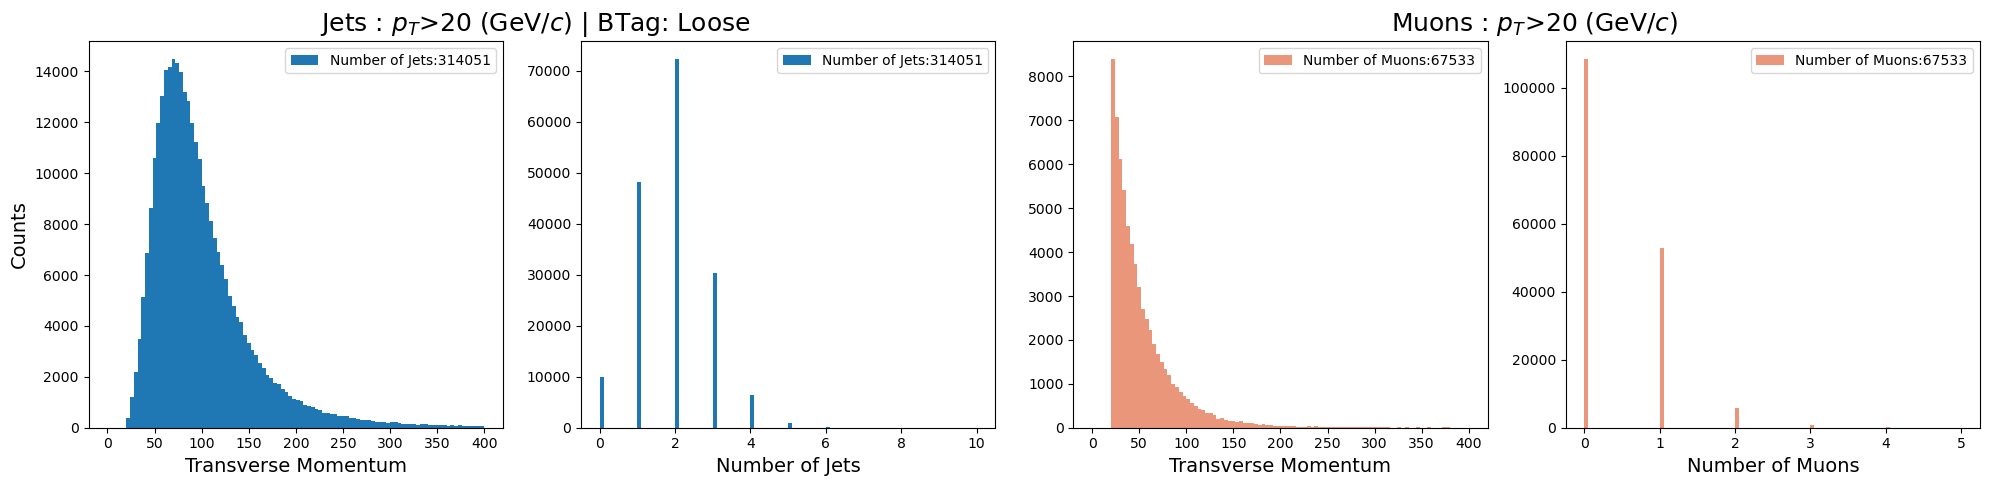

In [21]:
main(events_keys=events, pt_cut_vals=[20], btag_cut="Loose", plot=True)

<TTree 'Events' (1504 branches) at 0x7f681dbee9d0>

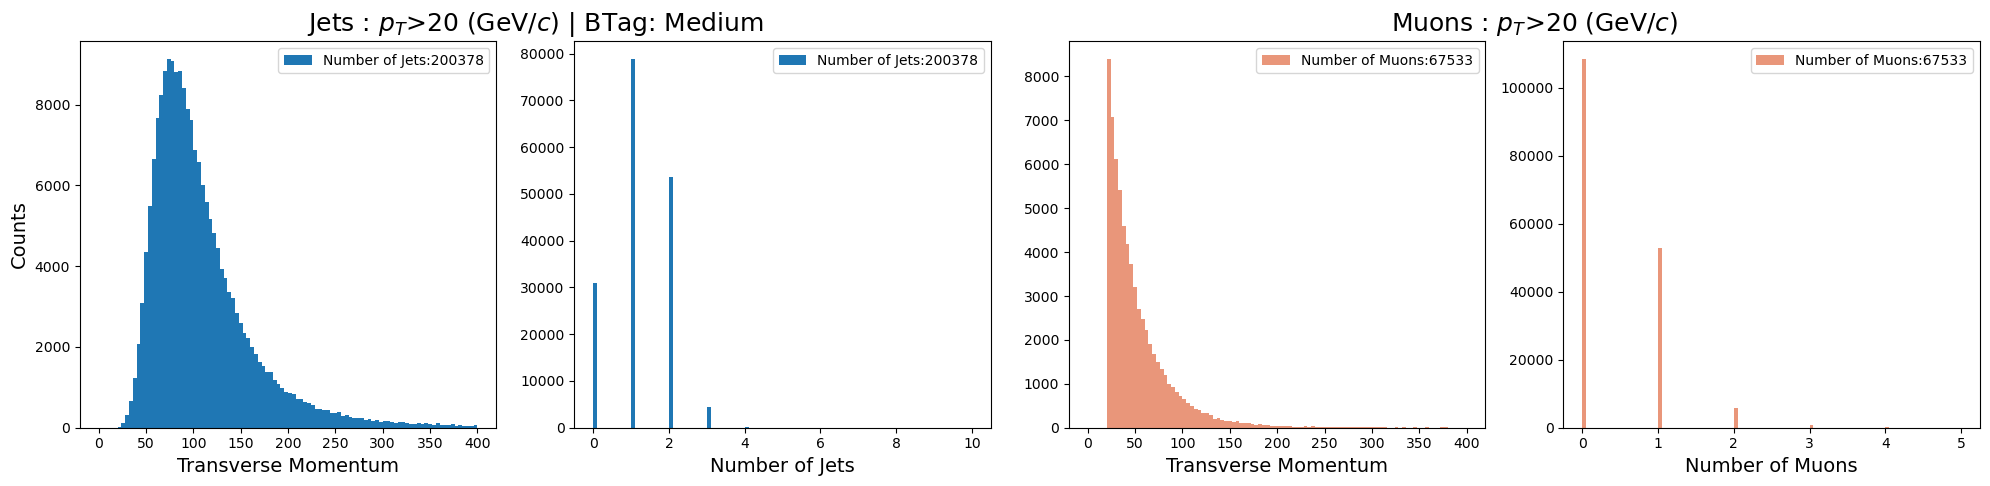

In [22]:
main(events_keys=events, pt_cut_vals=[20], btag_cut="Medium", plot=True)

<TTree 'Events' (1504 branches) at 0x7f681dbee9d0>

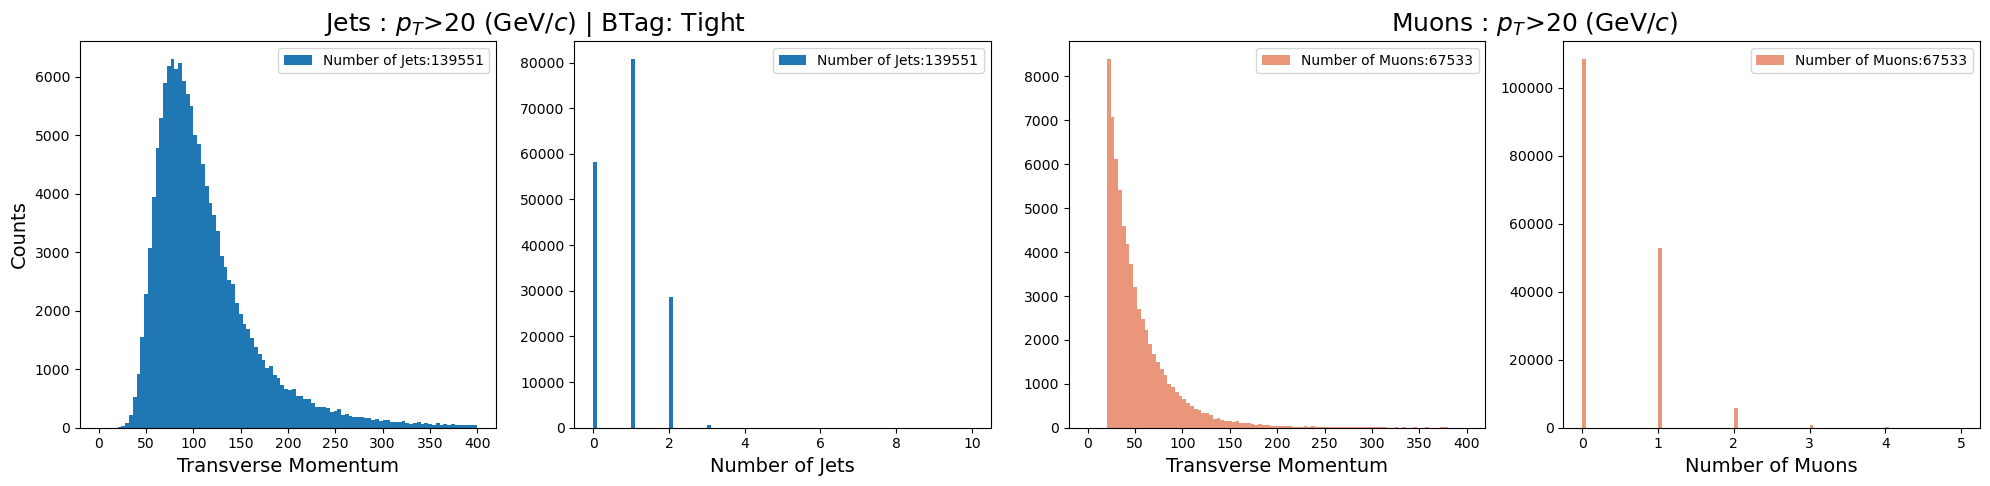

In [25]:
main(events_keys=events, pt_cut_vals=[20], btag_cut="Tight", plot=True)

In [26]:
jet_btagB = events["Jet_btagDeepB"].array()
jet_btag_flavB = events["Jet_btagDeepFlavB"].array()
x_vals = {
    "Loose": [0.1918, 0.0480, "purple"],
    "Medium": [0.5847, 0.2489, "yellow"],
    "Tight": [0.8767, 0.6377, "red"]
}

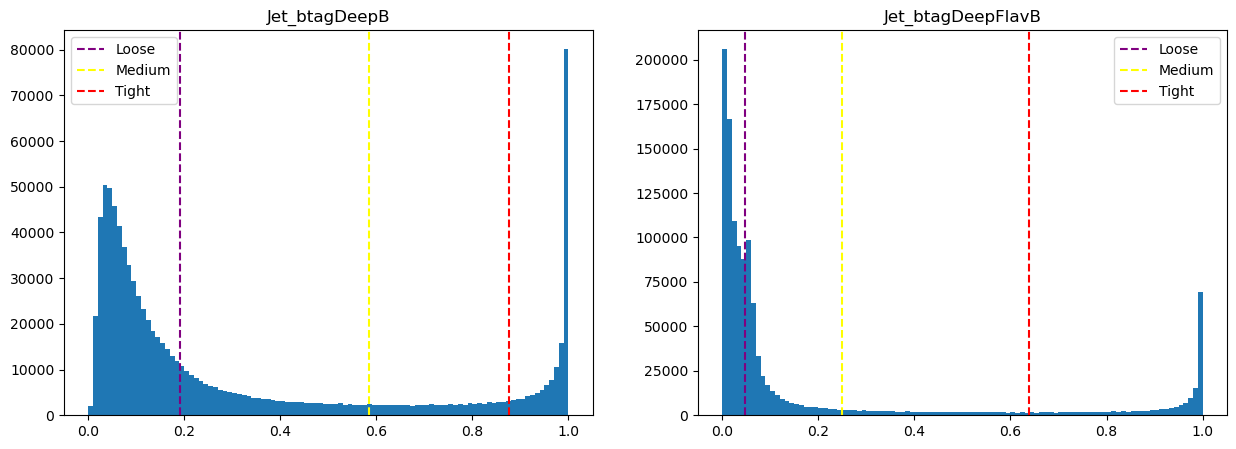

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.hist(ak.flatten(jet_btagB), bins=100, range=(0,1));
for val in x_vals:
    plt.axvline(x_vals[val][0], color=x_vals[val][-1], linestyle='--', label=val)
plt.title("Jet_btagDeepB")
plt.legend();

plt.subplot(1,2,2)

plt.hist(ak.flatten(jet_btag_flavB), bins=100, range=(0,1));
for val in x_vals:
    plt.axvline(x_vals[val][1], color=x_vals[val][-1], linestyle='--', label=val)
plt.title("Jet_btagDeepFlavB")
plt.legend();

In [30]:
pretty_print(events.keys(), fmt='40s', require=['Muon'], ignore='HLT')

Jet_nMuons                               L1PreFiringWeight_Muon_Nom               
L1PreFiringWeight_Muon_StatDn            L1PreFiringWeight_Muon_StatUp            
L1PreFiringWeight_Muon_SystDn            L1PreFiringWeight_Muon_SystUp            
nMuon                                    Muon_dxy                                 
Muon_dxyErr                              Muon_dxybs                               
Muon_dz                                  Muon_dzErr                               
Muon_eta                                 Muon_ip3d                                
Muon_jetPtRelv2                          Muon_jetRelIso                           
Muon_mass                                Muon_miniPFRelIso_all                    
Muon_miniPFRelIso_chg                    Muon_pfRelIso03_all                      
Muon_pfRelIso03_chg                      Muon_pfRelIso04_all                      
Muon_phi                                 Muon_pt                                  
Muon

In [71]:
muon_pt_cut = muon_pt>20
muon_cut = muon_pt_cut
muon_pt[muon_cut]

<Array [[40.7], [], [46.9], ..., [28.6], [63.1]] type='168000 * var * float32'>

In [113]:
nJets = events["nJet"].array()
n4Jets = nJets[nJets > 4]

In [114]:
test = (nJets == ak.num(events["Jet_nMuons"].array()))
for val in test:
    if val == False:
        print("Not the same")
    else:
        continue